In [1]:
import re
import os
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(250, 250), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)
df['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df['img_250']))

100%|██████████| 13404/13404 [00:05<00:00, 2556.06it/s]


In [3]:
def create_circular_mask(h, w, center=None, radius=None):
    # Создает круговую маску изображения, с требуемым радиусом
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_height_map(img):
    # Получает граффик высот пятна
    m = np.zeros((15))
    for r in range(0, 30, 2):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-2))
        m[r//2] = np.sum(mask * (img-100.4)) / np.sum(mask)
    m -= m.min()
    m /= m.max()
    return m


def get_histogram_map(img, radius_0=7, radius_1=30):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(100, 120), bins=20)[0]
    
    return m

def get_img_spector(img):
    sum_img = np.sum(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    std_img = np.std(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    
    histogram_map_0_7 = get_histogram_map(img, 0, 6)
    histogram_map_7_30 = get_histogram_map(img, 6, 30)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    
    height_map = get_height_map(img)
    spector = np.concatenate([std_img, np.array(kurtosis(height_map)).reshape(-1), sum_img])
    #spector = np.concatenate([std_img, np.array(kurtosis(height_map)).reshape(-1), sum_img])
    #spector = np.concatenate([histogram_map_0_7, histogram_map_7_30, height_map, sum_img, std_img])
    return spector

def get_circular_ratio(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.995)
    r = np.sqrt(np.sum(gaussian_mask)/np.pi)
    mask = create_circular_mask(250, 250, radius=r)
    return np.sum(mask*gaussian_mask)/np.sum(mask+gaussian_mask)

def get_bright_sum(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.98)#112
    return np.sum(img[gaussian_mask]-100.4)/1000

In [4]:
def get_random_noise_hist(img, hist_range=(80, 140), bins=60):
    mask = ~create_circular_mask(250, 250, radius=30)
    img = img * mask
    return np.histogram(img, range=hist_range, bins=bins)[0] / np.sum(mask)


def get_histogram_map(img, radius_0=8, radius_1=15):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(80, 140), bins=60)[0] / np.sum(mask)
    
    return m

In [5]:
random_noise_hist = np.sum(Parallel(n_jobs=c.NUM_CORES)(delayed(get_random_noise_hist)(img, hist_range=(80, 140), bins=60) for img in tqdm(df[df.t==1]['img_250'])), axis=0)

100%|██████████| 6646/6646 [00:03<00:00, 1857.98it/s]


In [6]:
random_noise_hist = np.sum(Parallel(n_jobs=c.NUM_CORES)(delayed(get_random_noise_hist)(img, hist_range=(80, 140), bins=60) for img in tqdm(df[df.t==1]['img_250'])), axis=0) / len(df[df.t==1]['img_250'])

100%|██████████| 6646/6646 [00:03<00:00, 1883.25it/s]


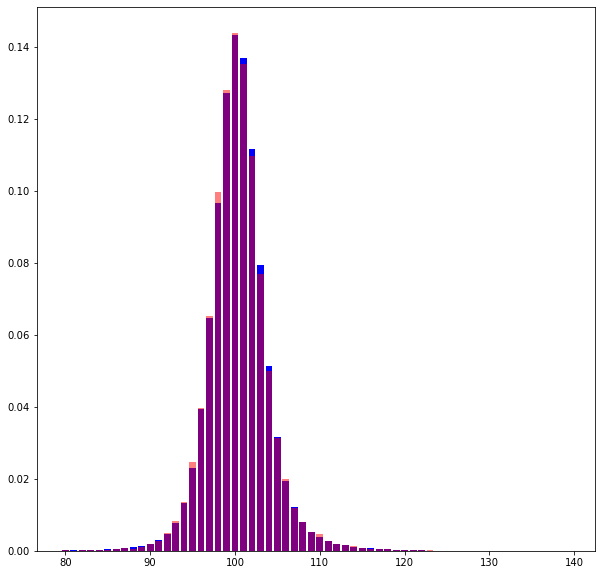

In [7]:
plt.bar(np.arange(80, 140, 1), random_noise_hist, width = 0.8, color='b')
plt.bar(np.arange(80, 140, 1), get_random_noise_hist(df[df.t==1]['img_250'][1]), width = 0.8, color='r', alpha=0.5)
plt.show()

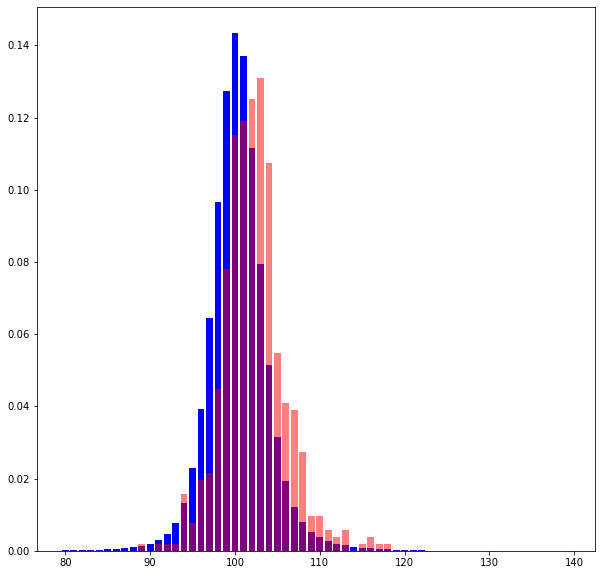

In [8]:
plt.bar(np.arange(80, 140, 1), random_noise_hist, width = 0.8, color='b')
plt.bar(np.arange(80, 140, 1), get_histogram_map(df[df.t==1]['img_80'][0]), width = 0.8, color='r', alpha=0.5)
plt.show()

In [231]:
df['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df['img_250'])))
df['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df['img_250'])))

df_center_shifted = df[((df.circular_ratio<0.8)&(df.bright_sum>5))]
df = df[~((df.circular_ratio<0.8)&(df.bright_sum>5))]

df['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df['img_250']))
df['img_80'] = df['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)

100%|██████████| 9028/9028 [00:06<00:00, 1428.03it/s]


In [14]:
df['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df['img_80']))

100%|██████████| 9028/9028 [00:42<00:00, 211.27it/s]


In [15]:
df.head()

,t,e,img_250,img_80,circular_ratio,bright_sum,spector
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....","[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",0.884146,3.486998,"[40.81663513183594, -1.3736760390376546, 12899..."
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....","[[100.380005, 100.200005, 102.36, 97.5, 97.62,...",0.925234,10.607998,"[43.46559524536133, -1.3882567428840797, 13651..."
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....","[[101.14, 101.880005, 102.6, 100.94, 100.92, 1...",0.913313,9.111998,"[42.779327392578125, -1.395732821154118, 13459..."
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...","[[96.26, 100.5, 95.42, 97.18, 99.68, 101.42, 1...",0.919255,10.104999,"[43.09930419921875, -1.3965786517093128, 13546..."
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...","[[98.82, 107.0, 98.66, 102.44, 101.46, 99.54, ...",0.878419,12.223998,"[44.0062255859375, -1.374916011041052, 137931...."


In [278]:
from sklearn.metrics import mean_poisson_deviance

In [148]:
def get_histogram_matrix(img, max_r):
    hists = []
    for r in range(max_r):
        mask = create_circular_mask(80, 80, radius=r+3) * (~create_circular_mask(80, 80, radius=r))
        hist, bins = np.histogram(img[mask], range=(80, 180), bins=100)
        hists.append(hist/np.sum(mask))
    return np.array(hists) * (max_r - np.arange(1, max_r+1).reshape(-1, 1))

In [149]:
df['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df['img_80']))

100%|██████████| 9028/9028 [00:03<00:00, 2875.54it/s]


In [150]:
np.mean(df['hist_matrix'][0], axis=1)

array([0.15, 0.14, 0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05,
       0.04, 0.03, 0.02, 0.01, 0.  ])

In [284]:
np.max(mean_hist_matrix.reshape(-1))

2.095363869020282

In [294]:
mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==1)]['hist_matrix'])
df['error_t1e1'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==6)]['hist_matrix'])
df['error_t1e6'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==20)]['hist_matrix'])
df['error_t1e20'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==3)]['hist_matrix'])
df['error_t0e3'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==10)]['hist_matrix'])
df['error_t0e10'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

In [295]:
df.corr()['t']

t                         1.000000
e                         0.335247
circular_ratio           -0.316123
bright_sum                0.243203
error_t1e1               -0.015683
error_t1e6                0.451837
error_t1e20              -0.275489
error_t0e3                0.510654
error_t0e10              -0.110493
predict                   0.998561
particle_types_predict    0.998289
mean_img_error_t1e6       0.307928
mean_img_error_t1e1       0.265065
mean_img_error_t0e3       0.321891
Name: t, dtype: float64

In [296]:
df.corr()['t']

t                         1.000000
e                         0.335247
circular_ratio           -0.316123
bright_sum                0.243203
error_t1e1               -0.015683
error_t1e6                0.451837
error_t1e20              -0.275489
error_t0e3                0.510654
error_t0e10              -0.110493
predict                   0.998561
particle_types_predict    0.998289
mean_img_error_t1e6       0.307928
mean_img_error_t1e1       0.265065
mean_img_error_t0e3       0.321891
Name: t, dtype: float64

In [297]:
mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==1)]['hist_matrix'])
a=df[(df.t==1)&(df.e==1)]['hist_matrix'].map(lambda hist_matrix: mean_absolute_error(np.transpose(mean_hist_matrix, (1, 0)), np.transpose(hist_matrix, (1, 0)), multioutput='raw_values') )

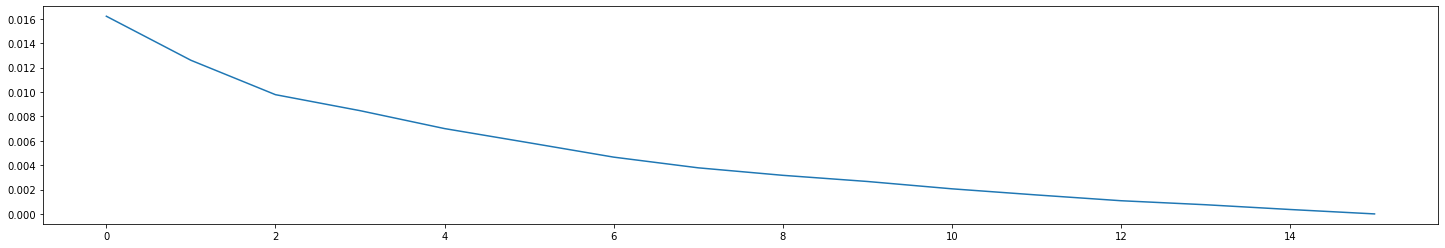

In [298]:
plt.plot(np.std(np.array(a.to_list()), axis=0))

In [299]:
df

,t,e,img_250,img_80,circular_ratio,bright_sum,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,predict,particle_types_predict,img_80_circular,mean_img_error_t1e6,mean_img_error_t1e1,mean_img_error_t0e3
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....","[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",0.884146,3.486998,"[40.81663513183594, -1.3736760390376546, 12899...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.089621,0.032815,0.127006,0.036447,0.101584,0.985262,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.537597,4.341945,2.692320
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....","[[100.380005, 100.200005, 102.36, 97.5, 97.62,...",0.925234,10.607998,"[43.46559524536133, -1.3882567428840797, 13651...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.136832,0.128730,0.040113,0.131616,0.064313,0.987338,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",25.251123,39.071026,25.392618
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....","[[101.14, 101.880005, 102.6, 100.94, 100.92, 1...",0.913313,9.111998,"[42.779327392578125, -1.395732821154118, 13459...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.131731,0.116460,0.050482,0.118215,0.052960,0.985203,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.600407,27.623585,16.817171
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...","[[96.26, 100.5, 95.42, 97.18, 99.68, 101.42, 1...",0.919255,10.104999,"[43.09930419921875, -1.3965786517093128, 13546...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.134351,0.123721,0.039474,0.126379,0.053145,0.987338,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",21.029377,33.446903,21.257915
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...","[[98.82, 107.0, 98.66, 102.44, 101.46, 99.54, ...",0.878419,12.223998,"[44.0062255859375, -1.374916011041052, 137931....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.136321,0.128800,0.046150,0.131614,0.072065,0.987347,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",34.891815,50.991100,35.044594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13394,0,3,"[[94.0, 107.0, 97.0, 97.0, 101.0, 97.0, 101.0,...","[[101.92, 100.3, 97.72, 106.64, 99.520004, 99....",0.884146,3.268998,"[40.46708679199219, -1.2326699568996422, 12787...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.076895,0.033119,0.130850,0.031587,0.105823,0.033417,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.781797,4.036243,2.644354
13396,0,3,"[[102.0, 99.0, 102.0, 101.0, 101.0, 101.0, 97....","[[105.020004, 98.8, 103.6, 110.32, 99.94, 98.6...",0.937304,3.569998,"[40.59738540649414, -1.2370356048577642, 12826...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.084810,0.035811,0.128411,0.029992,0.099661,0.034485,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.846817,4.894886,2.606159
13397,0,3,"[[98.0, 100.0, 100.0, 100.0, 98.0, 102.0, 100....","[[101.380005, 99.200005, 101.86, 108.78, 100.2...",0.937304,3.802998,"[40.64213562011719, -1.2284171988470858, 12841...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.083934,0.038912,0.128708,0.032020,0.100869,0.033648,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.689415,4.716643,2.457996
13398,0,3,"[[107.0, 98.0, 97.0, 101.0, 99.0, 98.0, 100.0,...","[[99.24, 100.200005, 96.18, 103.98, 97.32, 99....",0.878419,3.220398,"[40.63188934326172, -1.2772980134486802, 12839...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.079344,0.034286,0.128720,0.034540,0.103902,0.033254,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.879974,4.372777,2.857520


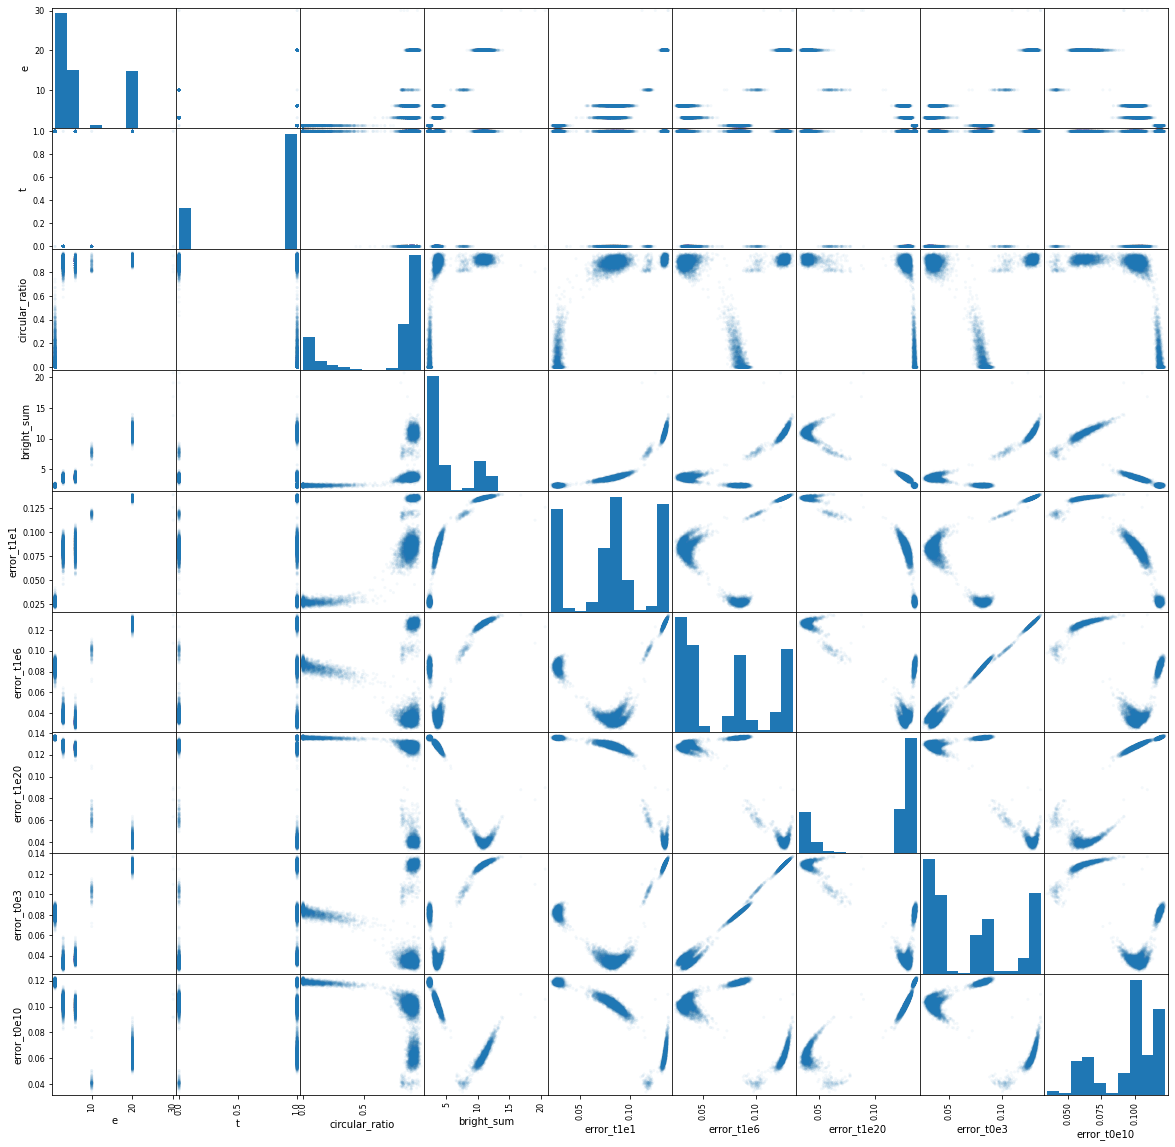

In [300]:
scatter_matrix(df[['e', 't', 'circular_ratio', 'bright_sum', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']], alpha=0.05, figsize=(20, 20));

In [407]:
df.head()

,t,e,img_250,img_80,circular_ratio,bright_sum,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,predict,particle_types_predict,img_80_circular,mean_img_error_t1e6,mean_img_error_t1e1,mean_img_error_t0e3
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....","[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",0.884146,3.486998,"[40.81663513183594, -1.3736760390376546, 12899...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.089621,0.032815,0.127006,0.036447,0.101584,0.996872,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.537597,4.341945,2.692320
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....","[[100.380005, 100.200005, 102.36, 97.5, 97.62,...",0.925234,10.607998,"[43.46559524536133, -1.3882567428840797, 13651...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.136832,0.128730,0.040113,0.131616,0.064313,0.997457,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",25.251123,39.071026,25.392618
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....","[[101.14, 101.880005, 102.6, 100.94, 100.92, 1...",0.913313,9.111998,"[42.779327392578125, -1.395732821154118, 13459...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.131731,0.116460,0.050482,0.118215,0.052960,0.997348,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.600407,27.623585,16.817171
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...","[[96.26, 100.5, 95.42, 97.18, 99.68, 101.42, 1...",0.919255,10.104999,"[43.09930419921875, -1.3965786517093128, 13546...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.134351,0.123721,0.039474,0.126379,0.053145,0.997457,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",21.029377,33.446903,21.257915
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...","[[98.82, 107.0, 98.66, 102.44, 101.46, 99.54, ...",0.878419,12.223998,"[44.0062255859375, -1.374916011041052, 137931....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.136321,0.128800,0.046150,0.131614,0.072065,0.997394,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",34.891815,50.991100,35.044594


In [416]:
df[(df.t==0)&(df.e==1)]['circular_ratio']

11077    0.548872
11269    0.433875
13403    0.467933
Name: circular_ratio, dtype: float64

In [620]:
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6)]
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6) | (df.t==0)&(df.e==10) | (df.t==1)&(df.e==20)]
df_ = df[(df.bright_sum<3)&(df.bright_sum<20)]

x = df_[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_['spector'].to_numpy().tolist(), x], axis=1)
y = df_.t.to_numpy().reshape(-1, 1)
print(len(x))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

2300


In [621]:
np.mean(y)

0.9656521739130435

In [622]:
particle_types_model = CatBoostClassifier(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train), y_train), roc_auc_score(particle_types_model.predict(x_test), y_test))

1.0 0.9988751406074241


0.9994941831057158 0.999268688530963

In [623]:
particle_types_model = CatBoostRegressor(iterations=150,
                          learning_rate=3e-2,
                          l2_leaf_reg=1.0,  # any pos value
                          depth=6,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

1.0 1.0


0.9994941831057158 0.999268688530963

In [624]:
particle_types_model = LinearRegression().fit(x_train, y_train)
particle_types_model.score(x_train, y_train)


print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

0.9766541822721599 0.9810861423220975


0.9965376562113499 0.9970495659880614

In [625]:
from sklearn import ensemble
particle_types_model = ensemble.RandomForestClassifier(n_estimators=50, random_state=11)
particle_types_model.fit(x_train, y_train)

print(roc_auc_score(y_train, particle_types_model.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model.predict(x_test)>0.5))

1.0 0.9691332718390215


<ipython-input-625-48312a83b91a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  particle_types_model.fit(x_train, y_train)


In [626]:
from sklearn import ensemble
particle_types_model = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
particle_types_model.fit(x_train, y_train)

print(roc_auc_score(y_train, particle_types_model.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model.predict(x_test)>0.5))

C:\Users\Kirill\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1.0 0.9685695739810735


In [619]:
df_['predict'] = particle_types_model.predict(x)
df_['particle_types_predict'] = (particle_types_model.predict(x)>0.5)*1
df_[df_.t!=df_.particle_types_predict]#.head()

<ipython-input-619-d0dca639e5af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['predict'] = particle_types_model.predict(x)
<ipython-input-619-d0dca639e5af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['particle_types_predict'] = (particle_types_model.predict(x)>0.5)*1


,t,e,img_250,img_80,circular_ratio,bright_sum,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,predict,particle_types_predict,img_80_circular,mean_img_error_t1e6,mean_img_error_t1e1,mean_img_error_t0e3
1926,1,1,"[[104.0, 101.0, 104.0, 96.0, 96.0, 101.0, 104....","[[99.22, 100.4, 102.3, 95.86, 98.42, 100.66, 9...",0.417431,2.446998,"[40.132781982421875, -1.3543637304764375, 1268...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.033956,0.066797,0.134355,0.067024,0.115832,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.584788,2.628072,3.703369
11077,0,1,"[[103.0, 99.0, 99.0, 98.0, 96.0, 102.0, 102.0,...","[[103.14, 107.28, 97.72, 104.16, 108.36, 99.5,...",0.548872,2.636998,"[40.123863220214844, -1.2386152952122202, 1268...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.039771,0.068613,0.134822,0.068321,0.116498,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.329129,2.474591,3.377890
13403,0,1,"[[96.0, 100.0, 101.0, 99.0, 103.0, 104.0, 102....","[[101.04, 98.82, 97.04, 96.04, 104.86, 102.14,...",0.467933,2.458998,"[40.05286407470703, -1.165697736991484, 126624.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.036502,0.068135,0.134834,0.067659,0.115382,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.559441,2.536374,3.571442


In [607]:
df[(df.t==0)&(df.e==6)]

,t,e,img_250,img_80,circular_ratio,bright_sum,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,predict,particle_types_predict,img_80_circular,mean_img_error_t1e6,mean_img_error_t1e1,mean_img_error_t0e3


In [608]:
df_ = df[(df.t==0)&(df.e==6) | (df.t==1)&(df.e==10)]

x = df_[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_['spector'].to_numpy().tolist(), x], axis=1)
y = df_.t.to_numpy().reshape(-1, 1)

print(y)
particle_types_model.predict(x)

[[1]
 [1]]


array([1, 1], dtype=int64)

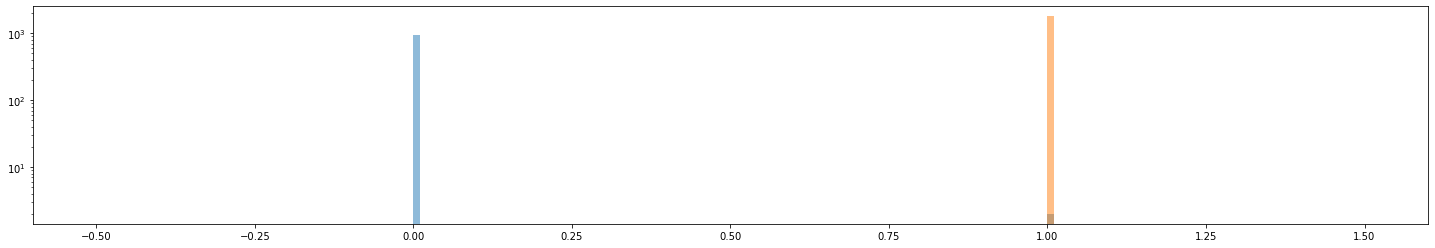

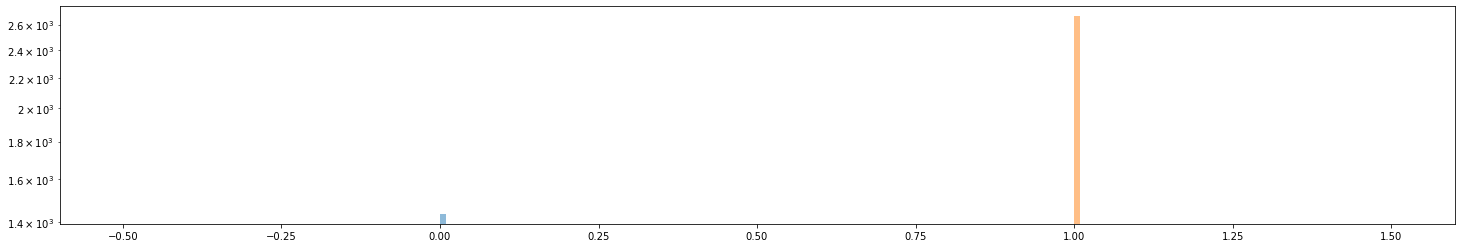

In [591]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [465]:
x = df[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df['spector'].to_numpy().tolist(), x], axis=1)
y = df.t.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

In [466]:
df['predict'] = particle_types_model.predict(x)
df['particle_types_predict'] = (particle_types_model.predict(x)>0.5)*1
df[df.t!=df.particle_types_predict]#.head()

,t,e,img_250,img_80,circular_ratio,bright_sum,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,predict,particle_types_predict,img_80_circular,mean_img_error_t1e6,mean_img_error_t1e1,mean_img_error_t0e3
30,1,1,"[[102.0, 98.0, 103.0, 103.0, 99.0, 101.0, 97.0...","[[100.82, 99.840004, 100.08, 97.08, 93.48, 103...",0.000000,2.318998,"[39.99409103393555, -1.0479287395100108, 12644...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.025265,0.085869,0.136429,0.082484,0.120419,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.167285,2.399660,4.269996
37,1,1,"[[103.0, 102.0, 100.0, 104.0, 100.0, 98.0, 102...","[[99.92, 99.04, 106.1, 106.68, 101.74, 99.96, ...",0.063683,2.160998,"[40.05784225463867, -1.2906229740125195, 12664...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.028037,0.079938,0.135616,0.077522,0.117973,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.903189,2.486532,4.033217
47,1,1,"[[102.0, 102.0, 103.0, 99.0, 97.0, 100.0, 98.0...","[[99.9, 98.22, 97.96, 105.74, 91.16, 97.96, 99...",0.033445,2.570998,"[39.90823745727539, -1.2679814603053217, 12617...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.028582,0.093533,0.135853,0.090129,0.119842,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.195437,2.299465,4.329398
48,1,1,"[[107.0, 100.0, 100.0, 102.0, 98.0, 104.0, 113...","[[100.74, 100.86, 101.44, 103.98, 101.1, 101.3...",0.138122,2.273998,"[40.00914001464844, -0.932954247119345, 126492...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.027578,0.080708,0.137011,0.078263,0.120259,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.104474,2.428232,4.178372
61,1,1,"[[96.0, 103.0, 96.0, 103.0, 101.0, 100.0, 101....","[[99.46, 96.200005, 100.020004, 93.58, 100.74,...",0.373333,2.474998,"[40.06721496582031, -1.2931186380395279, 12667...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.031189,0.075753,0.134923,0.075055,0.118288,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.776497,2.484454,3.872011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6610,1,1,"[[108.0, 100.0, 100.0, 105.0, 91.0, 104.0, 102...","[[98.86, 99.54, 100.78, 99.8, 99.700005, 101.0...",0.078534,2.368998,"[39.963226318359375, -1.099679292783862, 12635...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.028078,0.085115,0.136214,0.082104,0.119065,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.990339,2.207825,4.089845
6641,1,1,"[[101.0, 102.0, 98.0, 98.0, 99.0, 98.0, 102.0,...","[[105.62, 103.22, 99.060005, 90.04, 93.98, 102...",0.000000,2.479998,"[39.9007453918457, -1.1220124999830863, 126156...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.026082,0.085077,0.136613,0.083282,0.120382,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.081349,2.244835,4.123868
6645,1,1,"[[107.0, 105.0, 99.0, 106.0, 101.0, 104.0, 101...","[[100.0, 100.54, 98.86, 103.6, 100.78, 99.5600...",0.040404,2.176998,"[40.01716232299805, -1.2975803560279782, 12652...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.026410,0.084135,0.136213,0.082640,0.119172,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.138088,2.346990,4.264959
6816,0,3,"[[97.0, 101.0, 100.0, 100.0, 101.0, 101.0, 98....","[[100.68, 98.26, 100.32, 107.94, 105.74, 99.68...",0.828402,2.988998,"[40.48601531982422, -1.319045003768553, 127952...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.072584,0.033282,0.130331,0.036614,0.105730,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.943730,3.760436,2.937066


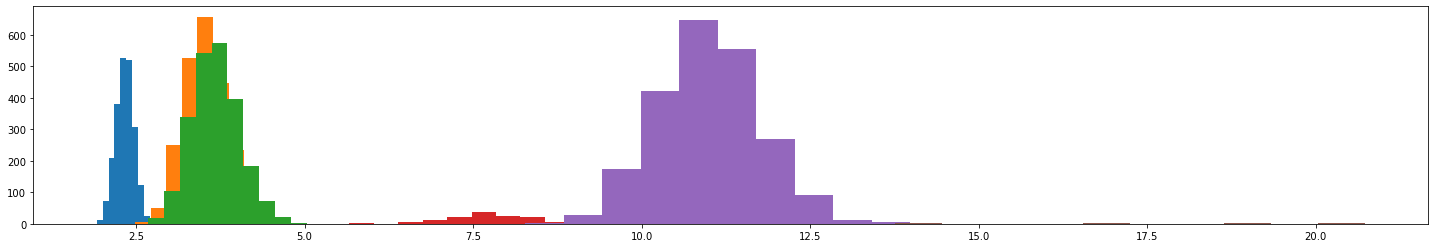

In [598]:
for e in [1, 3, 6, 10, 20, 30]:
    plt.hist(df[df.e==e].bright_sum)

# ~~~

In [627]:
def get_private_test_data(input_shape=c.INPUT_SHAPE):
    x = []
    file_names = []
    data_dir = os.path.join(c.DATASET_DIR, 'private_test')
    for root, dirs, files in os.walk(data_dir):
        x += Parallel(n_jobs=c.NUM_CORES) \
            (delayed(get_x)(file, data_dir, input_shape, False, False, False) for file in tqdm(files))
        file_names += files
    df = pd.DataFrame(file_names, columns=['file_names'])
    df['id'] = df['file_names'].map(lambda file_name: file_name[:-4])
    df['img_' + str(input_shape[0])] = x
    return df

In [ ]:
df_private = get_private_test_data((250, 250))

In [638]:
df_private['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df_private['img_250'])))
df_private['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df_private['img_250'])))
df_private['is_center_shifted'] = ((df_private.circular_ratio<0.8)&(df_private.bright_sum>5))

100%|██████████| 15058/15058 [00:14<00:00, 1007.29it/s]


In [668]:
mask = create_circular_mask(250, 250, radius=8)

In [672]:
df_private['sum'] = df_private['img_250'].map(lambda img: np.sum(img[mask])/np.sum(mask)-100.4)

In [673]:
df_private['is_center_shifted'] = ((df_private.circular_ratio<0.8)&(df_private.bright_sum>5))

In [682]:
len(df_private)

15058

In [685]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']<7.5)

5042

In [678]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']>30)

2522

In [686]:
np.sum((30>df_private[~df_private['is_center_shifted']]['sum'])&(df_private[~df_private['is_center_shifted']]['sum']>7.5))

3925

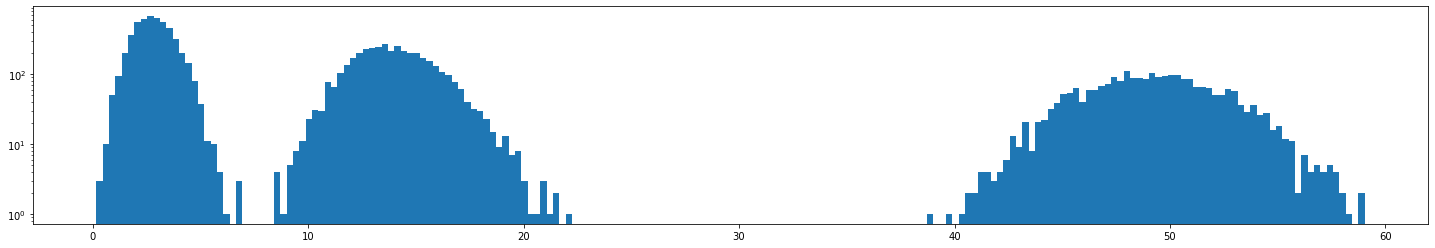

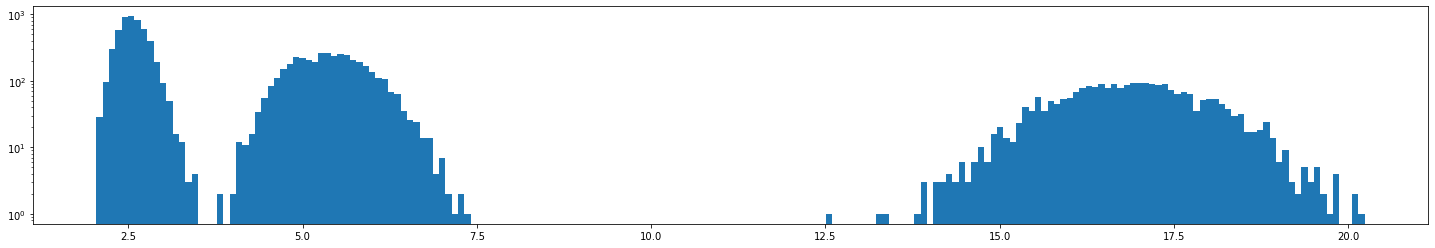

In [687]:
plt.hist(df_private[~df_private['is_center_shifted']]['sum'], bins=200, log=True)
plt.show()

plt.hist(df_private[~df_private['is_center_shifted']]['bright_sum'], bins=200, log=True)
plt.show()

#### Далее классифицируем оба вида частиц по энергиям отдельно, как можно заметить классификация очень точная.


In [430]:
df_t0 = df[df.t==0]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = df_t0[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_t0['spector'].to_numpy().tolist(), x], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [431]:
energies_model_t0 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t0.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t0.predict(x_train), y_train), mean_absolute_error(energies_model_t0.predict(x_test), y_test))

0.06341908248094091 0.058577061418284705


In [432]:
energies_model_t0 = LinearRegression().fit(x_train, y_train)
energies_model_t0.score(x_train, y_train)

0.9712407765896783

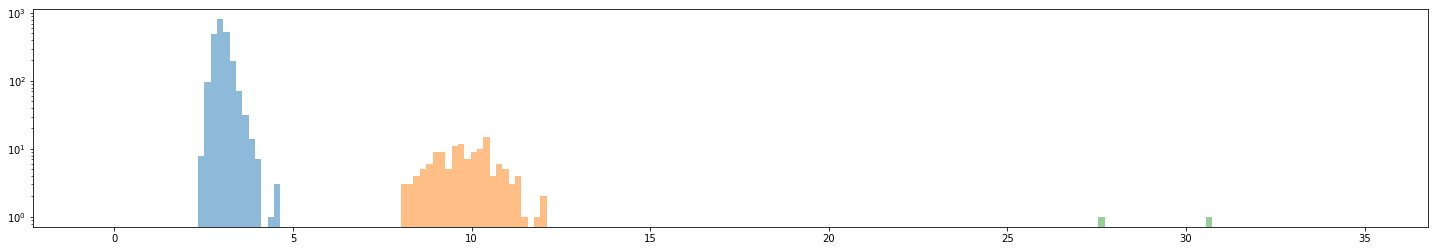

In [433]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

Классификация по энергиям частиц NR:

In [434]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([1, 6, 20])]

x = df_t0[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_t0['spector'].to_numpy().tolist(), x], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [435]:
energies_model_t1 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t1.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t1.predict(x_train), y_train), mean_absolute_error(energies_model_t1.predict(x_test), y_test))

0.3589669819805687 0.3541322135248068


In [436]:
energies_model_t1 = LinearRegression().fit(x_train, y_train)
energies_model_t1.score(x_train, y_train)

0.9954656048193463

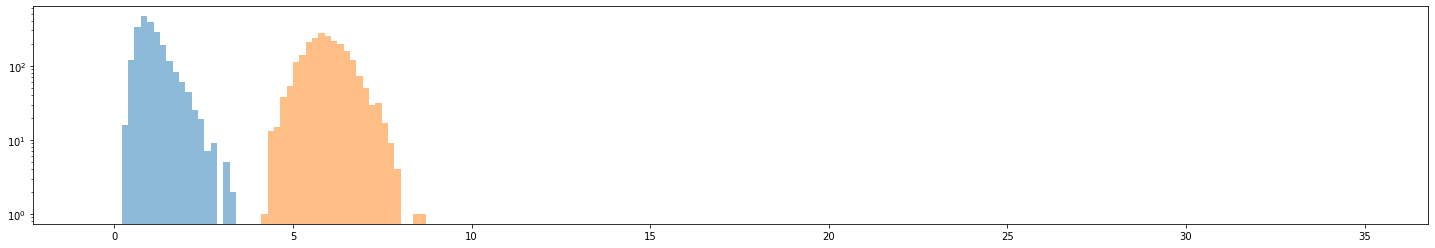

In [437]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==6]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
#plt.hist(energies_model.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

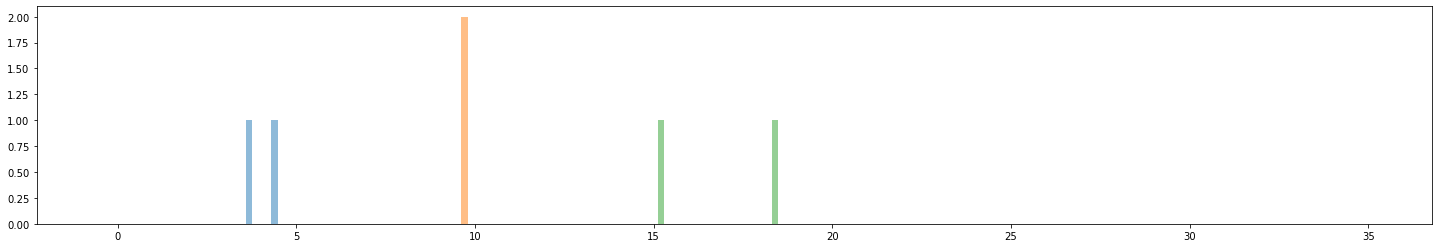

In [438]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = df_t0[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_t0['spector'].to_numpy().tolist(), x], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.show()

## Используем полученные модели для классификации тестовых данных

In [349]:
df_test = get_test_data(input_shape=(250, 250))
df_test['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df_test['img_250'])))
df_test['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df_test['img_250'])))


100%|██████████| 1502/1502 [00:01<00:00, 976.59it/s]

100%|██████████| 1502/1502 [00:02<00:00, 710.50it/s]

100%|██████████| 1502/1502 [00:01<00:00, 1105.23it/s]


In [350]:
df_test['id'] = df_test['file_names'].map(lambda file_name: file_name[:-4])

In [351]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998


In [439]:
df_test['is_center_shifted'] = ((df_test.circular_ratio<0.8)&(df_test.bright_sum>5))

df_test['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df_test['img_250']))
df_test['img_80'] = df_test['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)
df_test['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df_test['img_80']))


100%|██████████| 1502/1502 [00:01<00:00, 1316.39it/s][A

100%|██████████| 1502/1502 [00:04<00:00, 353.60it/s]


In [440]:
df_test['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df_test['img_80']))


100%|██████████| 1502/1502 [00:00<00:00, 2068.68it/s]


In [363]:
mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==1)]['hist_matrix'])
df_test['error_t1e1'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==6)]['hist_matrix'])
df_test['error_t1e6'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==20)]['hist_matrix'])
df_test['error_t1e20'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==3)]['hist_matrix'])
df_test['error_t0e3'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==10)]['hist_matrix'])
df_test['error_t0e10'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

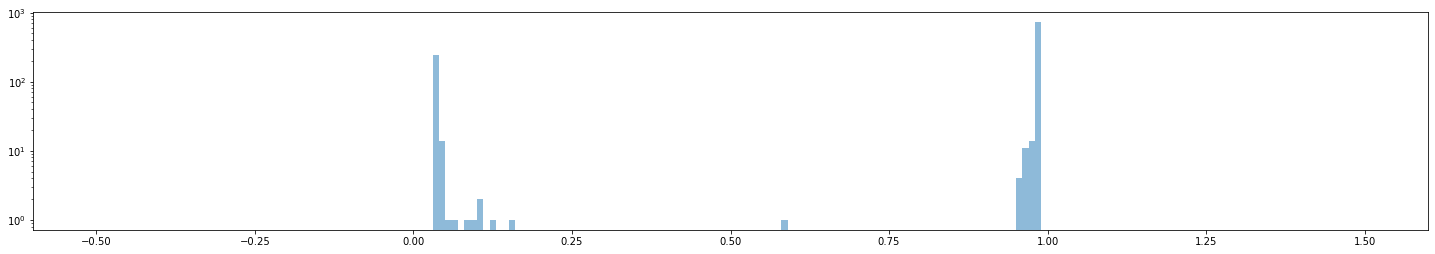

In [364]:
df_test_with_shifted_center = df_test[~df_test['is_center_shifted']]

x = df_test_with_shifted_center[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_test_with_shifted_center['spector'].to_numpy().tolist(), x], axis=1)


plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [441]:
x = df_test[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_test['spector'].to_numpy().tolist(), x], axis=1)
df_test['particle_types_model'] = particle_types_model.predict(x)

In [442]:
df_test['t'] = ((df_test.is_center_shifted)|(df_test.particle_types_model<0.5))*1

In [443]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum,is_center_shifted,img_80,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,particle_types_model,t,energies_predict_t0,energies_predict_t1
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998,False,"[[103.4, 99.74, 103.020004, 88.48, 96.8, 98.64...","[43.35074234008789, -1.3905653914049676, 13617...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.014572,0.013020,0.003970,0.013763,0.007161,0.987672,0,9.481989,19.482862
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998,False,"[[96.48, 102.98, 99.18, 100.840004, 101.74, 10...","[40.683685302734375, -1.4194284510275978, 1285...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007801,0.003376,0.013337,0.004176,0.009474,0.985874,0,3.032234,6.147138
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999,False,"[[104.32, 98.26, 103.22, 100.42, 96.1, 107.58,...","[43.72025680541992, -1.3898656675759586, 13713...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.014730,0.013545,0.004013,0.014192,0.007743,0.987672,0,9.481989,19.484106
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998,False,"[[97.380005, 100.4, 98.22, 111.18, 96.5, 100.7...","[40.63819122314453, -1.4000766278244174, 12842...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007970,0.003646,0.013460,0.004256,0.009606,0.986457,0,3.032234,6.147138
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998,False,"[[99.12, 102.8, 99.42, 107.18, 98.9, 103.56000...","[40.539207458496094, -1.4131502296642886, 1281...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007500,0.003800,0.013877,0.004359,0.009865,0.984911,0,3.027816,6.147739


In [444]:
df_test['energies_predict_t0'] = energies_model_t0.predict(x)
df_test['energies_predict_t1'] = energies_model_t1.predict(x)

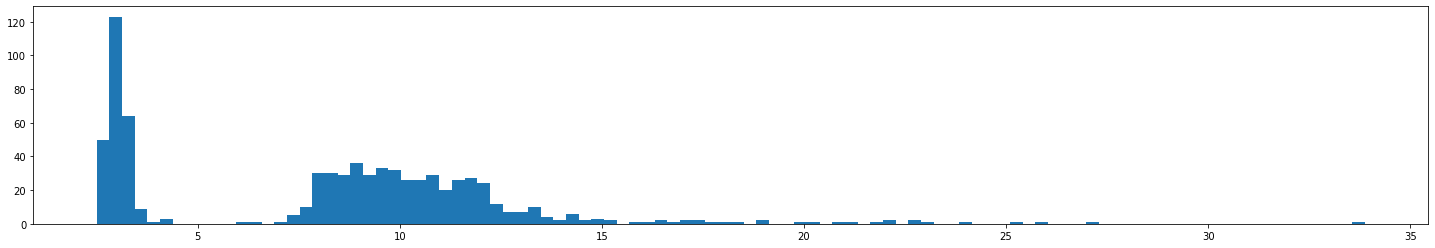

In [445]:
plt.hist(df_test[df_test.t==1]['energies_predict_t0'], bins=100)
plt.show()

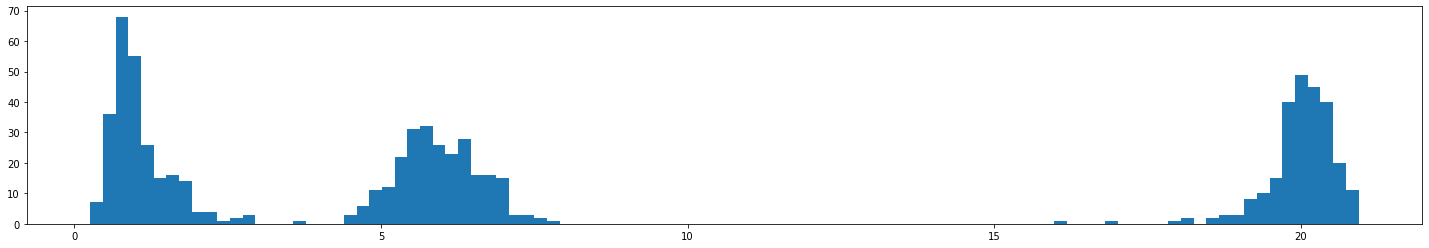

In [446]:
plt.hist(df_test[df_test.t==0]['energies_predict_t1'], bins=100)
plt.show()

In [447]:
df_test['e'] = 0
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (0<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<6)) * 3
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15)) * 10
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (15<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<30)) * 30

df_test['e'] += ((df_test.t==0) & (0<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<4)) * 1
df_test['e'] += ((df_test.t==0) & (4<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<8)) * 6
df_test['e'] += ((df_test.t==0) & (8<df_test['energies_predict_t1'])) * 20

df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] < 12)) * 10
df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] > 12)) * 30

In [448]:
np.sum((df_test.t==0) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15))

250

In [449]:
df_test[df_test.t==0]['energies_predict_t0']

0       11.039456
1        3.546762
2       12.644608
3        3.396902
4        3.181197
          ...    
1489    10.882610
1490     3.429808
1496     5.045518
1499    10.684397
1501     4.399476
Name: energies_predict_t0, Length: 753, dtype: float64

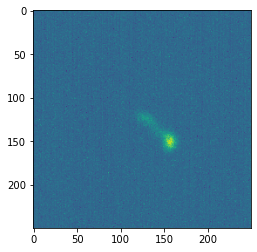

In [450]:
plt.imshow(df_test[(df_test.t==1)].iloc[1].img_250)

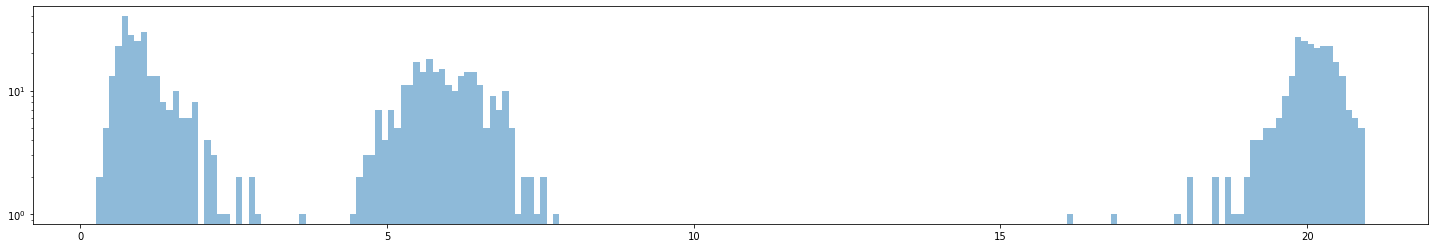

In [451]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(df_test[(df_test.t==0)]['energies_predict_t1'], bins=200, alpha=0.5, log=True)
plt.show()

In [460]:
def get_private_test_data():
    file_names = []
    data_dir = os.path.join(c.DATASET_DIR, 'private_test')
    for root, dirs, files in os.walk(data_dir):
        file_names += files
    df = pd.DataFrame(file_names, columns=['file_names'])
    df['id'] = df['file_names'].map(lambda file_name: file_name[:-4])
    df['classification_predictions'] = 1
    df['regression_predictions'] = 1
    return df


In [461]:
submission = get_private_test_data()
submission

,file_names,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96.png,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0.png,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d.png,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34.png,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc.png,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...,...
15053,ffe6d929d9537cf9b718711a63e41a1b57b509c2.png,ffe6d929d9537cf9b718711a63e41a1b57b509c2,1,1
15054,ffea775cbac98273943841d63b08377d29f08bc7.png,ffea775cbac98273943841d63b08377d29f08bc7,1,1
15055,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580.png,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,1,1
15056,ffed718417c6923844d33e70491c54396e3ec1ed.png,ffed718417c6923844d33e70491c54396e3ec1ed,1,1


In [482]:
submission = pd.concat([submission, df_test])#pd.merge(submission, df_test, how="outer", on=['id'])
submission = submission.fillna(1, axis=0)

In [483]:
submission.e = 1

In [484]:
submission = submission[['id', 't', 'e']]
submission.t = submission.t.astype(int)
submission.e = submission.e.astype(int)
submission = submission.rename(columns={"t": "classification_predictions", "e": "regression_predictions"})

In [485]:
submission.to_csv('submission.csv', index=False)

In [486]:
submission

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...
1497,ff343a62752061d995f94ebc10ac53f79d1b5ab1,1,1
1498,ff897755cb312cd6f510ba7a38cb293e648d97d5,1,1
1499,ff9a93402457ac514cd069a7ce3f2e32692f5290,0,1
1500,ffedc12ec5c142dae2086408b778cf0db2ff944e,1,1
